In [1]:
%%capture
# Running the previous notebooks
%run TSP.ipynb
%run TSPextended.ipynb
%run LocalSearch.ipynb

#Importing their classes
tsp = TSP()
tsp_ext = TSPext()
localsearch = LocalSearch()

Importing the relevant packages.
We require the following:

In [2]:
import pandas as pd
import numpy as np
from numpy import random as npr
import matplotlib.pyplot as plt
import copy
import warnings

In [3]:
#Importing the distance dataframe for testing
columns = [i for i in range(1,26)]
distance_dataframe_test = pd.read_csv('distance_dataframes/dist_dataframe_normal_1_25_wo:9.csv',names = columns)
distance_dataframe_test = distance_dataframe_test.iloc[1:]
#Importing the synthetic dataset
#synthetic_data_w = pd.read_csv('synthetic_data_w.csv', index_col='Unnamed: 0')

For representation, we will a numpy array $([1,...,n])$ to denote the set of cities in the network. A valid route through the network will be a numpy array $([l_1,...,l_n])$ which represents the order of cities in which they are visited, where $l_1,...,l_n \in \{1,...,n\}$. 

For the fitness evaluation, we need to resolve the conflict between the fact that Evolutionary Algorithms are designed to optimize solutions for maximization problems, while the optimal solution for the TSP is a route with the minimum cost. To do this, we will define the function $NegativeRouteCost$, which will return $SumCost \times -1$. The optimal solution, the solution with the minimum tour cost, will be the solution that maximizes $NegativeRouteCost$.

In [4]:
def NegativeRouteCost(route, distanceMatrix):
    
    cost = -1 * tsp.getCostofRoute(route, distanceMatrix)
    return(cost)    

The function $CandidatePopulation$ takes as input the number of cities in a network and the desired population size for the Evolutionary Algorithm, and returns the corresponding $pandas$ $Dataframe$ to contain the population.

In [5]:
def CandidatePopulation(population_size,number_of_cities):
    
    #Creating the population_sizexnumber_of_cities with (i,j) == 1.
    population = np.ones((population_size, number_of_cities), dtype=int)
    
    #List of node indices
    index = list(range(1, number_of_cities+1))
    index = np.array(index)
    
    #List of population indices
    pop_index = list(range(1, population_size+1))
    pop_index = np.array(pop_index)
    
    df = pd.DataFrame(population, index=pop_index, columns=index)
    
    return(df)

The function $RandomCandidate$ takes the value of the number of cities in a network ($n$) and returns a random route (from $1$ to $n$) as an numpy array.

In [6]:
def RandomCandidate(number_of_cities):    
        #List of node indices
        index = list(range(1, number_of_cities+1))
        
        index = copy.deepcopy(index)
                
        maximum = max(index)
        
        #Initializing the random route as an empty index 
        random_route = []
        
        #Removing node 0 from the index
        #index.remove(0)
        
        #Creating a random generator
        rng = npr.default_rng()

        #Choosing a random city and adding it to random_route
        choose = rng.choice(index)
        random_route.append(choose)

        for i in range(maximum-1):
                #Removing the city from index
                index = [x for x in index if x != choose]

                #Choosing a new random city and adding it to random route
                choose = rng.choice(index)
                random_route.append(choose)
        
        random_route = np.array(random_route)

        return(random_route)

The function $RandomPopulation$ takes as input the number of cities in a network, and the desired size of the population to undergo artificial evolution, and returns a corresponding $pandas$ $Dataframe$ filled with random solutions.

In [7]:
def RandomPopulation(population_size, number_of_cities):
    
    #Initializing the database to hold the random candidates
    initialization = CandidatePopulation(population_size, number_of_cities)
    
    #Creating random candidates and adding them to the database
    for j in range(1,population_size+1):
        
        random_route = RandomCandidate(number_of_cities)
        
        initialization.loc[j] = random_route
    
    return(initialization)

The function $TwoOptPopulation$ uses $randomtwoOptSearchAlgorithm$ to generate a population, where each individual in the population is randomly generated and then optimized using the $2-opt$ swap.

In [8]:
def TwoOptPopulation(population_size, number_of_cities, distance_dataframe):
    
    #Initializing the database to hold the random candidates
    initialization = CandidatePopulation(population_size, number_of_cities)
    
    #
    for j in range(1,population_size+1):
        heuristic_route = localsearch.Search(distance_dataframe, method = "Random_2opt", total_time = 1) 
        heuristic_route = heuristic_route[1]
        initialization.loc[j] = heuristic_route
    
    return(initialization)

We need a structure that holds information about each candidate solution and its associated fitness score. For this, we can define the function $GlobalEvaluation$, which returns an dataframe with number of columns $n \times 1$, where each entry $i$ in the $n \times 1$ column is the fitness score for solution $i$.

In [9]:
def GlobalEvaluation(population, distance_dataframe):
    
    #Initializing a numpy array of ones to hold the scores for each individual
    scores = np.ones(len(population))
    
    #Populating scores array with the score for each population
    for i in range(len(population)):
        tmp = population.iloc[i]
        new_index_values = range(len(distance_dataframe))
        tmp.index = new_index_values
        scores[i]= NegativeRouteCost(tmp, distance_dataframe)
    
    
    population_copy = copy.deepcopy(population)
    
    #Adding the scores for each individual in the population column
    population_copy['Fitness'] = scores
    
    return(population_copy)    

In order to have the flexibility of evaluating the population from either the dataframe or the city_cooridnates, the function $GlobalEvaluationcc$ allows the user to perform evaluation using city coordinates.

In [10]:
def GlobalEvaluationcc(population, city_coordinates):
    
    #Initializing a numpy array of ones to hold the scores for each individual
    scores = np.ones(len(population))
    
    #Populating scores array with the score for each population
    for i in range(len(population)):
            tmp = population.iloc[i]
            new_index_values = range(len(city_coordinates))
            tmp.index = new_index_values
            individual_fitness = []
            for j in range(len(tmp)-1):
                cost_of_traversing_between_nodes = tsp_ext.EuclideanDistanceCalculator(tmp[j], tmp[j+1], city_coordinates)
                individual_fitness.append(cost_of_traversing_between_nodes)
            loop_back = tsp_ext.EuclideanDistanceCalculator(tmp[len(tmp)-1], tmp[0], city_coordinates)
            individual_fitness.append(loop_back)
            individual_fitness = sum(individual_fitness)
            scores[i] = individual_fitness

    population_copy = copy.deepcopy(population)
    
    #Adding the scores for each individual in the population column
    population_copy['Fitness'] = scores * -1
    
    return(population_copy)    

We can now define the $Initialisation$ class.

In [11]:
class Initialisation:
    def __init__(self, population_size, number_of_cities, distance_dataframe):
        self.population_size = population_size
        self.number_of_cities = number_of_cities
        self.distance_dataframe = distance_dataframe
        self.population = 0
        self.database = 0
        self.evaluated_database = 0
        
    def GeneratePopulationDatabase(self):
        self.database = CandidatePopulation(self.population_size, self.number_of_cities)
        return self.database
    
    def RandomPopulationGenerator(self):
        self.population = RandomPopulation(self.population_size, self.number_of_cities)
        return self.population
    
    def HeuristicPopulationGenerator(self):
        self.population = TwoOptPopulation(self.population_size, self.number_of_cities, self.distance_dataframe)
        return self.population
    
    def EvaluatePopulation(self, population):
        self.evaluated_database = GlobalEvaluation(population, self.distance_dataframe)
        return self.evaluated_database

The function $tournamentSelection$ performs $k$-way tournament selection, where $k$ individuals are randomly chosen from an initial population, and the candidate with the highest score in this random sample is selected as a 'winner', i.e. its selected as a parent for the next iteration [1].

[1] https://www.tutorialspoint.com/genetic_algorithms/genetic_algorithms_parent_selection.htm

In [12]:
def tournamentSelection(initial_population, k):
    
    #Selecting k random members of the population to undergo tournament selection
    tournament = initial_population.sample(k, #random_state=42
                                               )
    
    #Obtaining the scores of the tournament population
    scores = tournament['Fitness']

    #Selecting the winners (the routes with the best score)
    ascending_indices = np.argsort(scores, axis=-1, order=None)
    ascending_indices = ascending_indices[::-1]
    
    winners = tournament.iloc[ascending_indices]
    winners = winners.iloc[0]
    
    return(winners)    

Parent selection is usually probabilistic, with a weighting to ensure that high fitness individuals have a greater probability of selection that low fitness individuals. We can adapt $tournamentSelection$ so that the individual with the highest fitness in each trial is selected with probability $p(1-p)^\alpha$, where $\alpha$ is the position of the individuals fitness on the table and $p$ is the probability parameter specified by the user [2].

[2] https://medium.com/@c4lv1nmcg0wan/genetic-algorithms-tournament-selection-b150bc76f0d8

In [13]:
def tournamentSelectionRandom(initial_population, k, p):
    warnings.filterwarnings('ignore')

    #Creating a random generator
    rng = npr.default_rng()
        
    #Selecting k random members of the population to undergo tournament selection
    tournament = initial_population.sample(k, #random_state=42)
    )
    #Obtaining the scores of the tournament population
    scores = tournament['Fitness']

    #Selecting the winners (the routes with the best score)
    #Rearraning tournamnet from highest to lowest fitness
    ascending_indices = np.argsort(scores, axis=-1, order=None)
    ascending_indices = ascending_indices[::-1]

    #Defining winners
    winners = tournament.iloc[ascending_indices]
    length_of_table = len(winners)
    
    #Creating the probability distribution
    probability_distribution = [(p * ((1-p)**a)) for a in range(length_of_table)]
    #Ensuring probabilities add to 1
    remainder = 1-sum(probability_distribution)
    probability_distribution[0] = probability_distribution[0] + remainder
    #Selecting the winner, with most fit candidate selected with probabilty p
    selection_index = rng.choice(winners.index, replace = False, p = probability_distribution)
    winner = winners.loc[[selection_index]]
    
    #winner = winner.iloc[:, :-1]
    
    return(winner)    

The function $RWSelection$ performs roulette wheel selection.

In [14]:
def RWSelection(population):
    #Creating a random generator
    rng = npr.default_rng()
    
    evaluted_population = population
    #Obtaining the total fitness
    #Determining the proportion of each individuals fitness value compared to the total fitness of the population
    evaluted_population['Inverse Fitness'] = evaluted_population['Fitness'] *-1
    evaluted_population['Inverse Fitness'] = 1/evaluted_population['Inverse Fitness'] 
    
    total_fitness = evaluted_population['Inverse Fitness'].sum()
    
    #Assiging RW probability to each individual
    evaluted_population["RW_Probability"] = evaluted_population["Inverse Fitness"]/total_fitness
    
    #Ordering the population from highest RW probability to lowest RW probability
    evaluted_population = evaluted_population.sort_values(by='RW_Probability', ascending=False)
    
    #Selecting the winner using RW_Probability distribution
    selection_index = rng.choice(evaluted_population.index, replace = False, p = evaluted_population["RW_Probability"])
    winner = evaluted_population.loc[[selection_index]]
    
    winner = winner.iloc[:, :-1]
    winner = winner.iloc[:, :-1]
    
    return(winner)

We can now define the $ParentSelection$ class.

In [15]:
class ParentSelection:
    def __init__(self, initial_population, tournament_size, tournament_probability, number_of_parents):
        self.initial_population = initial_population
        self.tournament_size = tournament_size
        self.number_of_parents = number_of_parents
        self.tournament_probability = tournament_probability
          
    def Tournament(self):
        self.parent = tournamentSelectionRandom(self.initial_population, self.tournament_size, self.tournament_probability)
        return(self.parent)


Crossover involves the production of offspring from one or more parents. The Order 1 Crossover (OX1) can be used for maintaining structural integrity of the relative ordering of TSP solutions, where solutions are represented as permutations of city labels [3].

The function $OX1Crossover$ takes as input two parents from the population, and returns the offspring produced as a result of the OX1 crossover, as well as the indices of the chunk of code that was copied from the first parent to the offspring. It selects the crossover points at random.

[3] https://www.tutorialspoint.com/genetic_algorithms/genetic_algorithms_crossover.htm

In [16]:
def OX1Crossover(parent_one, parent_two):
    parent_one = pd.Series(parent_one)
    parent_two = pd.Series(parent_two)
    
    #Removing the fitness column
    parent_one = parent_one.drop('Fitness')
    parent_two = parent_two.drop('Fitness')
    
    #We are making the strict assumption that both parents are taken from the same population and have the same
    #length (which is to be expected)
    length_of_parents = len(parent_one)
    range_of_parents = range(length_of_parents)
        
    #Generating the offspring array
    offspring_one = np.zeros(length_of_parents)

    #Choosing the indices for the cut-off points in both parents
    #Create a random number generator using the numpy.random module
    rng = npr.default_rng()
    #We can use the 'choice' method to uniformly select two parent indices
    cutoff_point_one, cutoff_point_two = rng.choice(range_of_parents, 2, replace = False)
    #Ordering the parent indices 
    ordered_indices = np.sort([cutoff_point_one, cutoff_point_two])

    #Copying the section of the genotype between the cut-off points from parent_one to offspring_one
    elements_stage1 = parent_one[ordered_indices[0]:ordered_indices[1]]
    offspring_one[ordered_indices[0]:ordered_indices[1]] = parent_one[ordered_indices[0]:ordered_indices[1]]

    #In this for loop, parameter "i" will run from cut-off point 2 to the end of parent_two, and copy across
    #alleles that are not present in offspring one. 
    j = 0
    p = 0

    for i in range(ordered_indices[1]+1, length_of_parents+1):
        if parent_two[i] in elements_stage1.values:
            pass      
        else:
            offspring_one[ordered_indices[1] + j] = parent_two[i]
                #parameter "j" acts as a marker to determine the current position index in offspring one (from the 
                #end of the block of code which was inserted)
            j = j+1
                
            
    # "t" will denote the index in offspring one at which the last allele from parent_two 
    # (in the range (ordered_indices[1], len(parent_one))) was copied across
    # It also denotes the position of the index in parent_two from which the last allele was copied
    t = ordered_indices[1] + j 
    
    #If t != length_of_parents, then we need to continue adding alleles to offspring_one from the
    # last position on parent_two, and then from the beginning of parent_two
    
    i = 0
    # "z" denotes the position of the counter across parent_two
    z = 1
    # "k" denotes the number of remaining indices to the right of the last-copied allele in offspring 1 
    k = (length_of_parents - t)
    
    while(i < k):
    #    #We can start copying alleles from the beginning of parent_two
        if parent_two[z] in elements_stage1.values:
    #        # Move to the next allele in parent_two
            z = z+1 
        else:
            offspring_one[t] = parent_two[z]
    #        # Move the index across by one in parent_two
            z = z+1 
    #        # Move the index across by one in offspring_one
            t = t+1
    #        # The numnber of free places left in offspring_one decreases by one
            i = i+1

    #We now need to fill the free spaces at the beginning of offspring_one with the remaining alleles from parent_two
    
    #Defining parameter "index" which will measure the position in offspring_one
    index = 0
    z = int(z)

    #Copying elements from parent_two from the end point of the previous loop
    for i in range(z, ordered_indices[1]+1):
        if parent_two[i] in elements_stage1.values:
            pass
        else:
            offspring_one[index] = parent_two[i]
            #Moving the index across offspring_one
            index = index +1
        
    '''
    while(t < (len(parent_one))):
        for i in range(0, ordered_indices[0]):
            if parent_two[i] in elements_stage1:
                pass
            else:
                offspring_one[t] = parent_two[i]
                t = t+1    
    ''' 
    return(offspring_one)

The function $OX1Crossover\_special$ is required later on for use with the $FSTSP$ model. It is the same as $OX1Crossover$ except that it also returns the indices for the cut-off points.

In [17]:
def OX1Crossover_special(parent_one, parent_two):
    parent_one = pd.Series(parent_one)
    parent_two = pd.Series(parent_two)
    
    #Removing the fitness column
    parent_one = parent_one.drop('Fitness')
    parent_two = parent_two.drop('Fitness')
    
    #We are making the strict assumption that both parents are taken from the same population and have the same
    #length (which is to be expected)
    length_of_parents = len(parent_one)
    range_of_parents = range(length_of_parents)
        
    #Generating the offspring array
    offspring_one = np.zeros(length_of_parents)

    #Choosing the indices for the cut-off points in both parents
    #Create a random number generator using the numpy.random module
    rng = npr.default_rng()
    #We can use the 'choice' method to uniformly select two parent indices [4]
    cutoff_point_one, cutoff_point_two = rng.choice(range_of_parents, 2, replace = False)
    #Ordering the parent indices 
    ordered_indices = np.sort([cutoff_point_one, cutoff_point_two])

    #Copying the section of the genotype between the cut-off points from parent_one to offspring_one
    elements_stage1 = parent_one[ordered_indices[0]:ordered_indices[1]]
    offspring_one[ordered_indices[0]:ordered_indices[1]] = parent_one[ordered_indices[0]:ordered_indices[1]]

    #In this for loop, parameter "i" will run from cut-off point 2 to the end of parent_two, and copy across
    #alleles that are not present in offspring one. 
    j = 0
    p = 0

    for i in range(ordered_indices[1]+1, length_of_parents+1):
        if parent_two[i] in elements_stage1.values:
            pass      
        else:
            offspring_one[ordered_indices[1] + j] = parent_two[i]
                #parameter "j" acts as a marker to determine the current position index in offspring one (from the 
                #end of the block of code which was inserted)
            j = j+1
                
            
    # "t" will denote the index in offspring one at which the last allele from parent_two 
    # (in the range (ordered_indices[1], len(parent_one))) was copied across
    # It also denotes the position of the index in parent_two from which the last allele was copied
    t = ordered_indices[1] + j 
    
    #If t != length_of_parents, then we need to continue adding alleles to offspring_one from the
    # last position on parent_two, and then from the beginning of parent_two
    
    i = 0
    # "z" denotes the position of the counter across parent_two
    z = 1
    # "k" denotes the number of remaining indices to the right of the last-copied allele in offspring 1 
    k = (length_of_parents - t)
    
    while(i < k):
    #    #We can start copying alleles from the beginning of parent_two
        if parent_two[z] in elements_stage1.values:
    #        # Move to the next allele in parent_two
            z = z+1 
        else:
            offspring_one[t] = parent_two[z]
    #        # Move the index across by one in parent_two
            z = z+1 
    #        # Move the index across by one in offspring_one
            t = t+1
    #        # The numnber of free places left in offspring_one decreases by one
            i = i+1

    #We now need to fill the free spaces at the beginning of offspring_one with the remaining alleles from parent_two
    
    #Defining parameter "index" which will measure the position in offspring_one
    index = 0
    z = int(z)

    #Copying elements from parent_two from the end point of the previous loop
    for i in range(z, ordered_indices[1]+1):
        if parent_two[i] in elements_stage1.values:
            pass
        else:
            offspring_one[index] = parent_two[i]
            #Moving the index across offspring_one
            index = index +1
        
    '''
    while(t < (len(parent_one))):
        for i in range(0, ordered_indices[0]):
            if parent_two[i] in elements_stage1:
                pass
            else:
                offspring_one[t] = parent_two[i]
                t = t+1    
    ''' 
    return(offspring_one,ordered_indices)

#[4] https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.choice.html

The function $TwoOptSwapMutation$ takes as input an individual from the population and performs the $2-opt$ mutation, where 2 allele values in the chromosome swap positions. It applies this with probability $p_c$.

In [18]:
def TwoOptSwapMutation(parent, mutation_probability):
    #Removing the fitness column
    #parent = parent.drop('Fitness')

    mutated_parent = np.copy(parent)
    
    #Creating a random generator
    rng = npr.default_rng()

    #Creating the two opt neighbourhood
    two_opt_neighbourhood = twoOptSwap(mutated_parent)
    
    #Defining probability threshold
    probability = rng.uniform(0, 1) 
    
    if probability < mutation_probability:
        #Choosing a random member of the neighbourhood to move to
        index = rng.integers(len(two_opt_neighbourhood))
        mutated_parent = two_opt_neighbourhood[index]
    else:
        mutated_parent = mutated_parent  
        
    return(mutated_parent)  

We can now define the class $Variation$.

In [19]:
class Variation:
    def __init__(self):
        self.offspring1 = 0
        self.offspring2 = 0
        self.mutated_individual = 0
        
    def OrderOneCrossover(self, parent_one, parent_two):
        self.offspring1 = OX1Crossover(parent_one, parent_two)
        self.offspring2 = OX1Crossover(parent_two, parent_one)
        return (self.offspring1, self.offspring2)
    
    def TwoOptMutation(self, individual, mutation_probability):
        self.mutated_individual = TwoOptSwapMutation(individual, mutation_probability)
        return(self.mutated_individual)

We can now combine all those steps together to perform the run of the EA.
The following $eaTSP$ class allows the user to create an EA with specified components.

In [20]:
class eaTSP:
    def __init__(self, population_size, number_of_cities, distance_dataframe):
        #number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability
        self.population_size = population_size
        self.number_of_cities = number_of_cities
        self.distance_dataframe = distance_dataframe
        self.elite_individual = []
        
    def random_initialization(self):
        rinitialization = Initialisation(self.population_size, self.number_of_cities, self.distance_dataframe)
        self.unevaluated_population = rinitialization.RandomPopulationGenerator()
        self.evaluated_population = rinitialization.EvaluatePopulation(self.unevaluated_population)
        #Determing the fittest individuals
        fittest_value = self.evaluated_population["Fitness"].max()
        self.fittest_value = fittest_value
        fittest_individuals = self.evaluated_population[self.evaluated_population["Fitness"] == fittest_value]
        #Choosing a random member
        self.elite_individual = fittest_individuals.sample(n=1)
        
        return(self.unevaluated_population, self.evaluated_population)
    
    def heuristic_initialization(self):
        hinitialization = Initialisation(self.population_size, self.number_of_cities, self.distance_dataframe)
        self.unevaluated_population = hinitialization.HeuristicPopulationGenerator()
        self.evaluated_population = hinitialization.EvaluatePopulation(self.unevaluated_population)
        #Determing the fittest individuals
        fittest_value = self.evaluated_population["Fitness"].max()
        self.fittest_value = fittest_value
        fittest_individuals = self.evaluated_population[self.evaluated_population["Fitness"] == fittest_value]
        #Choosing a random member
        self.elite_individual = fittest_individuals.sample(n=1)
        
        return(self.unevaluated_population, self.evaluated_population)
    
    def parent_selection_tournament(self, evaluated_population, number_of_parents, tournament_size, tournament_probability):
        selection = ParentSelection(evaluated_population, tournament_size, tournament_probability, number_of_parents)
        mating_pool = CandidatePopulation(number_of_parents, self.number_of_cities)
        for i in range(number_of_parents):
            parent = selection.Tournament()
            mating_pool.iloc[i] = parent

        return(mating_pool)
    
    def parent_selection_RW(self, evaluated_population, number_of_parents):
        mating_pool = CandidatePopulation(number_of_parents, self.number_of_cities)
        for i in range(number_of_parents):
            parent = RWSelection(evaluated_population)
            mating_pool.iloc[i] = parent

        return(mating_pool)
    
    def order_one_crossover(self, mating_pool, number_of_offspring):
        rng = npr.default_rng()
        offspring_database = CandidatePopulation(number_of_offspring, self.number_of_cities)
        mating_pool = GlobalEvaluation(mating_pool, self.distance_dataframe)
        for i in range(number_of_offspring):
            parents_indices = rng.choice(mating_pool.index, 2, replace=False)
            parent_one = mating_pool.loc[parents_indices[0]]
            parent_two = mating_pool.loc[parents_indices[1]]
            offspring = OX1Crossover(parent_one, parent_two)
            offspring_database.iloc[i] = offspring
        return(offspring_database)
    
    def two_opt_swap(self, offspring_database, mutation_probability):
        mutated_offspring = []
        for i in range(1, len(offspring_database)+1): 
            parent = offspring_database.loc[i]
            mutated_parent= TwoOptSwapMutation(parent, mutation_probability)
            mutated_offspring.append(mutated_parent)
       
        mutated_offspring_df = pd.DataFrame(mutated_offspring)
        #Reindexing the city labels from 1 to n
        columns = [str(i + 1) for i in range(self.number_of_cities)]
        mutated_offspring_df.columns = columns
        
        #Reindexing population numbers from 1
        mutated_offspring_df.index = mutated_offspring_df.index + 1
        return(mutated_offspring_df)
    
    def evaluation(self, parents_df):
        total_costs = []
        for i in range(len(parents_df)):
            parent = parents_df.iloc[i]
            total_cost = NegativeRouteCost(parent, self.distance_dataframe)
            total_costs.append(total_cost)
        parents_df['Fitness'] = total_costs    
        return(parents_df)    
    
    def replacement(self, parents_df, offspring_df):
        #Survivor selection - Select individuals for new generation
        size_of_initial_population = self.population_size
        offspring_df.columns = self.evaluated_population.columns
        #Merging the parents and offspring dataframes
        next_population_df = pd.concat([parents_df, offspring_df], axis=0)
        next_population_df.reset_index(drop=True, inplace=True)
    
        #Ranking the offspring according to fitness
        next_population_df = next_population_df.sort_values(by ='Fitness', ascending=False)
        #next_population
        
        #Selection
        #Selecting the highest n individuals in the database, where n is the size of the initial population
        next_population_df = next_population_df.head(size_of_initial_population)
        
        #Resetting the index
        next_population_df.reset_index(drop=True, inplace=True)
        next_population_df.index += 1
        
        return(next_population_df)
    
        
    def replacementwelitism(self, parents_df, offspring_df):
        #Survivor selection - Select individuals for new generation
        size_of_initial_population = self.population_size
        offspring_df.columns = self.evaluated_population.columns
        #Merging the parents and offspring dataframes
        next_population_df = pd.concat([parents_df, offspring_df], axis=0)
        next_population_df.reset_index(drop=True, inplace=True)
    
        #Ranking the offspring according to fitness
        next_population_df = next_population_df.sort_values(by ='Fitness', ascending=False)
        #next_population
        
        #Selection
        #Selecting the highest n individuals in the database, where n is the size of the initial population
        next_population_df = next_population_df.head(size_of_initial_population)
        
        #Resetting the index
        next_population_df.reset_index(drop=True, inplace=True)
        next_population_df.index += 1
        
        #If elite individual is not present, replacing that member with the elite individual
        #Checking to see if elite individual is present in the dataframe:
        if (next_population_df['Fitness'] == self.fittest_value).any():
            next_population_df = next_population_df
        else:
            #Replacing least fit individual with the fittest individual
            next_population_df.iloc[-1] = self.elite_individual
        
        #Updating elite individual
        #Determing the fittest individuals
        fittest_individual = next_population_df.iloc[0]        
        self.elite_individual = fittest_individual
        self.fittest_value = fittest_individual['Fitness']
        
        #Ranking the offspring according to fitness
        next_population_df = next_population_df.sort_values(by ='Fitness', ascending=False)
    
        return(next_population_df)


The class $eaTSP\_ONE$ runs the EA on the following test case: 
- Initialisation: Random
- Parent Selection: Tournament
- Recombination: Order 1
- Mutation: Two-Opt Swap
- Replacement: Generational
- Elitisim: False

In [21]:
class eaTSP_ONE:
    def __init__(self, population_size, number_of_cities, distance_dataframe):
        #number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability
        self.population_size = population_size
        self.number_of_cities = number_of_cities
        self.distance_dataframe = distance_dataframe
        self.tsp = eaTSP(self.population_size, self.number_of_cities, self.distance_dataframe)
        
    #Initialize and evaluate population
    def initialize(self):
        self.unevaluated_population, self.evaluated_population = self.tsp.random_initialization()
        return(self.unevaluated_population, self.evaluated_population)
        
    #Run the loop  
    def mainLoop(self, number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability, total_generations):
        generation_number =0
        initial_population = self.evaluated_population
        self.fitness_array = []
        self.duplicates = []
        while(generation_number<total_generations):
            #Select parents
            mating_pool = self.tsp.parent_selection_tournament(self.evaluated_population, number_of_parents, tournament_size, tournament_probability)
            #Recombination
            offspring_database = self.tsp.order_one_crossover(mating_pool, number_of_offspring)
            #Mutation
            mutated_offspring_df = self.tsp.two_opt_swap(offspring_database, mutation_probability)
            #Evaluation
            offspring_with_fitness = self.tsp.evaluation(mutated_offspring_df)
            offspring_with_fitness.columns = initial_population.columns
            #Replacement
            next_population = self.tsp.replacement(self.evaluated_population, offspring_with_fitness)
            #Preparing for next generation
            self.evaluated_population = next_population
            self.unevaluated_population = next_population.drop(next_population.columns[-1], axis=1)
      
            fitness = next_population['Fitness'].max()
            self.fitness_array.append(fitness)
            
            duplicates_count = next_population.duplicated().sum()
            self.duplicates.append(duplicates_count)
            
            generation_number = generation_number + 1
        
        return(next_population)
        
    def printOptimumFitness(self):
        plt.plot(self.fitness_array, marker='x', linestyle='-')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title('Plot of Fitness against Generation Number')
        plt.show()
        
    def printDuplicateCount(self):
        plt.plot(self.duplicates, marker='x', linestyle='-')
        plt.xlabel('Generation')
        plt.ylabel('Duplicate Count')
        plt.title('Plot of Number of Duplicate Individuals against Generation Number')
        plt.show()

In [22]:
ea = eaTSP_ONE(100, 25, distance_dataframe_test)

In [23]:
ea.initialize()

(     1   2   3   4   5   6   7   8   9   10  ...  16  17  18  19  20  21  22  \
 1    19  16   8   1   6  12  20   3  25  17  ...  22  21   7   9  15  10  14   
 2    12  16   9  10   6  23  24   7  20   1  ...  18   4  25  15  13  11  14   
 3    24  23  13   6  25  20  21   2  14  15  ...  18   9  22   8  11  19  16   
 4    17  19   6   3  21   5  16   8  24  10  ...  22   9  15  14  25  13  12   
 5    21   6  20   4  18  16  14  17   1  13  ...  12  19   8  11  22   5  10   
 ..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
 96   20  13  16   8   1  11   9  23   6  25  ...   4  22  14  18   2   3  19   
 97   23   9  15  11   3  21  18  16   1  25  ...   6  12  14   4  10  20  19   
 98    6   2  16  13  14  21  19  20  25  24  ...  12  15   9  11  17  18  23   
 99   13  16  14  22   2   9  11  15  21  25  ...  12   8   1  24   4  10  20   
 100  16   6   7   8   9  24  18  10  17  15  ...   4  20  12   2  23  19  11   
 
      23  24  25  
 1    2

In [39]:
ea.mainLoop(75, 100, 2, 0.9, 0.5, 100)

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,Fitness
1,22.0,18.0,23.0,24.0,1.0,16.0,2.0,13.0,15.0,20.0,...,10.0,4.0,14.0,9.0,21.0,6.0,8.0,12.0,11.0,-4.41
2,22.0,18.0,23.0,24.0,1.0,16.0,13.0,2.0,15.0,20.0,...,10.0,4.0,14.0,9.0,21.0,6.0,8.0,12.0,11.0,-4.41
3,22.0,18.0,23.0,24.0,1.0,16.0,2.0,13.0,15.0,20.0,...,10.0,4.0,14.0,9.0,21.0,6.0,8.0,12.0,11.0,-4.41
4,22.0,18.0,23.0,24.0,1.0,16.0,2.0,13.0,15.0,20.0,...,10.0,4.0,14.0,9.0,21.0,6.0,8.0,12.0,11.0,-4.41
5,22.0,18.0,23.0,24.0,1.0,16.0,13.0,2.0,15.0,20.0,...,10.0,4.0,14.0,9.0,21.0,6.0,8.0,12.0,11.0,-4.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,22.0,18.0,23.0,24.0,1.0,16.0,2.0,13.0,15.0,20.0,...,10.0,4.0,14.0,9.0,21.0,6.0,8.0,12.0,11.0,-4.41
97,22.0,18.0,23.0,24.0,1.0,16.0,2.0,13.0,15.0,20.0,...,10.0,4.0,14.0,9.0,21.0,6.0,8.0,12.0,11.0,-4.41
98,22.0,18.0,23.0,24.0,1.0,16.0,2.0,13.0,15.0,20.0,...,10.0,4.0,14.0,9.0,21.0,6.0,8.0,12.0,11.0,-4.41
99,22.0,18.0,23.0,24.0,1.0,16.0,13.0,2.0,15.0,20.0,...,10.0,4.0,14.0,9.0,21.0,6.0,8.0,12.0,11.0,-4.41


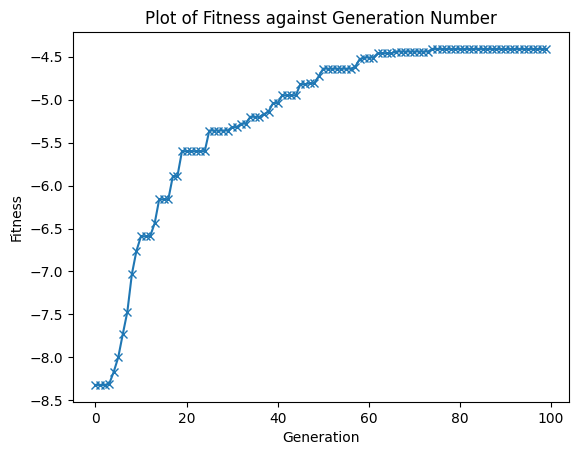

In [25]:
ea.printOptimumFitness()

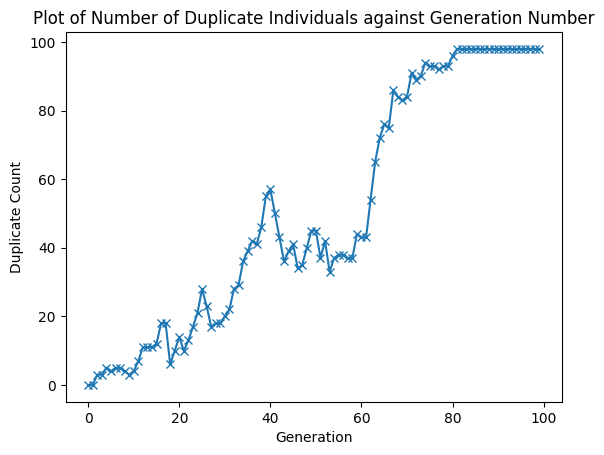

In [26]:
ea.printDuplicateCount()

The class $eaTSP\_TWO$ runs the EA on the following test case: 
- Initialisation: Random
- Parent Selection: Tournament
- Recombination: Order 1
- Mutation: Two-Opt Swap
- Replacement: Generational
- Elitisim: True

In [27]:
class eaTSP_TWO:
    def __init__(self, population_size, number_of_cities, distance_dataframe):
        #number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability
        self.population_size = population_size
        self.number_of_cities = number_of_cities
        self.distance_dataframe = distance_dataframe
        self.tsp = eaTSP(self.population_size, self.number_of_cities, self.distance_dataframe)
        
    #Initialize and evaluate population
    def initialize(self):
        self.unevaluated_population, self.evaluated_population = self.tsp.random_initialization()
        return(self.unevaluated_population, self.evaluated_population)
        
    #Run the loop  
    def mainLoop(self, number_of_parents, number_of_offspring, tournament_size, tournament_probability, mutation_probability, total_generations):
        generation_number =0
        initial_population = self.evaluated_population
        self.fitness_array = []
        self.duplicates = []
        while(generation_number<total_generations):
            #Select parents
            mating_pool = self.tsp.parent_selection_tournament(self.evaluated_population, number_of_parents, tournament_size, tournament_probability)
            #Recombination
            offspring_database = self.tsp.order_one_crossover(mating_pool, number_of_offspring)
            #Mutation
            mutated_offspring_df = self.tsp.two_opt_swap(offspring_database, mutation_probability)
            #Evaluation
            offspring_with_fitness = self.tsp.evaluation(mutated_offspring_df)
            offspring_with_fitness.columns = initial_population.columns
            #Replacement
            next_population = self.tsp.replacementwelitism(self.evaluated_population, offspring_with_fitness)
            #Preparing for next generation
            self.evaluated_population = next_population
            self.unevaluated_population = next_population.drop(next_population.columns[-1], axis=1)
      
            fitness = next_population['Fitness'].max()
            self.fitness_array.append(fitness)
            
            duplicates_count = next_population.duplicated().sum()
            self.duplicates.append(duplicates_count)
            
            generation_number = generation_number + 1
        
        return(next_population)
        
    def printOptimumFitness(self):
        plt.plot(self.fitness_array, marker='x', linestyle='-')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title('Plot of Fitness against Generation Number')
        plt.show()
        
    def printDuplicateCount(self):
        plt.plot(self.duplicates, marker='x', linestyle='-')
        plt.xlabel('Generation')
        plt.ylabel('Duplicate Count')
        plt.title('Plot of Number of Duplicate Individuals against Generation Number')
        plt.show()

In [28]:
#Test
#Creating a population of 100
EAP = eaTSP_TWO(100, 25, distance_dataframe_test)

In [29]:
EAP.initialize()


(     1   2   3   4   5   6   7   8   9   10  ...  16  17  18  19  20  21  22  \
 1    16  21  22  25   9  14  19   7   8  13  ...  11  18  20  23  10   4  17   
 2    14  10   9  20  19   4  18  22  17  12  ...  21   8  11  16   5  25   7   
 3     6  10  17  23   4  13  22   7  15  12  ...  21  25   3  16   9  24   1   
 4    10   9   8   5   2  18   6   7  12  22  ...  15  14  23  25   4   3  11   
 5     1  10  16  17  13  21  25   3  12  18  ...  23   9   4   7  24   5  22   
 ..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
 96   20   9  22  10  14   8   2   5   1  13  ...  17   7   4  16   6  21  19   
 97    1  22  24  25  13   8   5   9  10  19  ...   2  18   7  23   4  11  14   
 98    7  14   9   2   5  21  23  13  22  20  ...  17  24  19  12  15  25   6   
 99    4  24  22  11   6  23  20  15   5   3  ...   2   7   9  10  14  25  12   
 100  17  22  21   8  16   3  14  24   4   6  ...  10   9  11  20  18  15   1   
 
      23  24  25  
 1    1

In [30]:
#Running the EA for 100 generations
# with 75 parents, 100 offspring, tournament size 2, tournament probability 0.9 and mutation probability of 0.5.
EAP.mainLoop(75, 100, 2, 0.9, 0.5, 100)

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,Fitness
1,10.0,4.0,14.0,18.0,22.0,11.0,12.0,8.0,6.0,21.0,...,24.0,3.0,17.0,19.0,2.0,13.0,16.0,1.0,23.0,-4.48
9,10.0,4.0,14.0,18.0,22.0,11.0,12.0,8.0,6.0,21.0,...,24.0,3.0,17.0,19.0,2.0,13.0,16.0,1.0,23.0,-4.48
2,10.0,4.0,14.0,18.0,22.0,11.0,12.0,8.0,6.0,21.0,...,24.0,3.0,17.0,19.0,2.0,13.0,16.0,1.0,23.0,-4.48
15,10.0,4.0,14.0,18.0,22.0,11.0,12.0,8.0,6.0,21.0,...,24.0,3.0,17.0,19.0,2.0,13.0,16.0,1.0,23.0,-4.48
14,10.0,4.0,14.0,18.0,22.0,11.0,12.0,8.0,6.0,21.0,...,24.0,3.0,17.0,19.0,2.0,13.0,16.0,1.0,23.0,-4.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,10.0,4.0,14.0,18.0,22.0,11.0,12.0,8.0,6.0,21.0,...,24.0,3.0,17.0,19.0,7.0,13.0,16.0,1.0,23.0,-4.51
40,10.0,4.0,14.0,18.0,22.0,11.0,12.0,8.0,6.0,21.0,...,24.0,3.0,17.0,19.0,7.0,13.0,16.0,1.0,23.0,-4.51
39,10.0,4.0,14.0,18.0,22.0,11.0,12.0,8.0,6.0,21.0,...,24.0,3.0,17.0,19.0,7.0,13.0,16.0,1.0,23.0,-4.51
38,10.0,4.0,14.0,18.0,22.0,11.0,12.0,8.0,6.0,21.0,...,24.0,3.0,17.0,19.0,7.0,13.0,16.0,1.0,23.0,-4.51


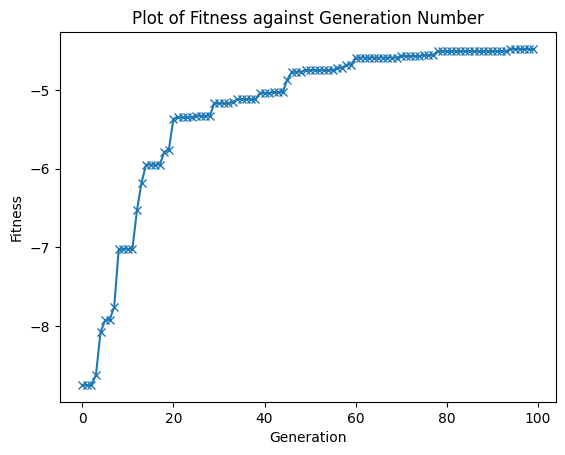

In [31]:
EAP.printOptimumFitness()

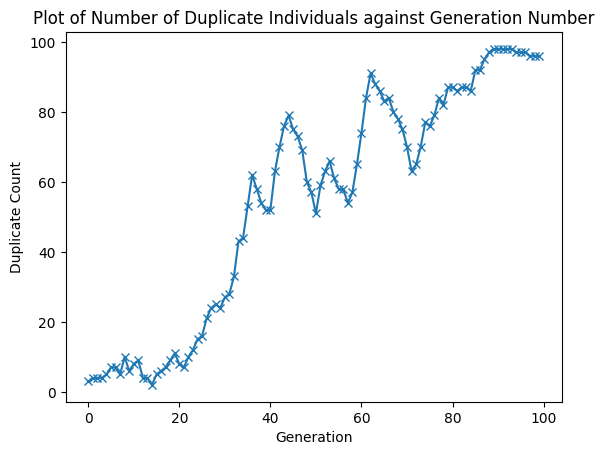

In [32]:
EAP.printDuplicateCount()

# Testing

In [33]:
#Creating a random population
tmp = RandomPopulation(100, 25).head()

In [34]:
#Creating a heuristic population
tmp2 = TwoOptPopulation(10, 25, distance_dataframe_test)

In [35]:
#Evaluating both populations and comparing them
GlobalEvaluation(tmp, distance_dataframe_test)

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,Fitness
1,16,1,15,22,2,4,7,5,19,18,...,3,17,6,11,21,24,20,13,9,-11.08
2,11,7,4,13,8,23,1,12,14,17,...,2,16,20,10,18,3,21,19,9,-11.55
3,9,19,25,7,18,6,13,23,21,10,...,8,11,4,16,24,2,12,5,17,-11.64
4,18,12,17,9,14,13,11,7,15,22,...,24,1,2,10,25,4,8,23,21,-12.32
5,18,23,6,13,14,10,3,25,8,7,...,22,4,12,2,9,1,17,15,19,-10.52


In [36]:
tmp3 = GlobalEvaluation(tmp2, distance_dataframe_test)
tmp3

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,Fitness
1,6,8,15,13,2,16,1,19,17,3,...,10,23,24,7,5,25,20,9,21,-5.00
2,8,11,12,22,18,1,16,9,15,13,...,4,14,23,24,5,25,20,21,6,-4.84
3,16,24,17,19,25,20,15,5,7,2,...,11,14,4,10,3,23,18,22,1,-4.88
4,9,21,6,8,12,11,22,5,25,20,...,10,3,17,19,7,24,23,1,16,-4.78
5,6,21,9,16,24,1,23,14,4,10,...,15,20,25,5,18,22,11,12,8,-4.53
6,17,19,23,11,12,8,6,21,9,15,...,16,1,24,18,22,14,4,10,3,-4.54
7,6,8,12,4,10,3,17,19,5,13,...,2,7,24,1,23,14,22,11,21,-5.27
8,1,16,6,21,9,20,15,13,2,7,...,14,8,12,11,22,18,23,3,24,-5.38
9,24,23,14,4,10,1,15,20,25,5,...,9,21,6,8,12,3,17,19,7,-5.49
10,21,9,20,25,5,19,17,3,10,4,...,15,16,1,18,22,11,12,8,6,-4.32


In [37]:
tmp4 = tournamentSelectionRandom(tmp3, 2, 0.9)
tmp4

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,Fitness
7,6,8,12,4,10,3,17,19,5,13,...,2,7,24,1,23,14,22,11,21,-5.27


In [38]:
tmp5 = tournamentSelectionRandom(tmp3, 2, 0.9)
tmp5

,1,2,3,4,5,6,7,8,9,10,...,17,18,19,20,21,22,23,24,25,Fitness
6,17,19,23,11,12,8,6,21,9,15,...,16,1,24,18,22,14,4,10,3,-4.54
